In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sciStat
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle
import os

# source /home/phbelang/abp/BBStudies/Executables/py_BB/bin/activate
if 'BBStudies/Executables/py_BB/bin' not in os.environ.get('PATH').split(':')[0]:
    raise Exception('Wrong Python Distribution, use BBStudies/Executables/py_BB')


import xobjects as xo
import xtrack as xt
import xpart as xp
import xfields as xf

sys.path.append('/home/phbelang/abp/BBStudies/')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst



def load_tracked(line_ID,sf=10):
    tracked = {}
    for label in ['ref','HO','LR','OCTU']:
        tracked[label] = pd.read_pickle(f'Tracking/tracked_{label}_sf{sf}_{line_ID}.pkl')
    tracked['coord'] = pd.read_pickle(f'Tracking/coordinates_{line_ID}.pkl')
    tracked['sf'] = sf
    return tracked

def load_tracked_FULL(line_ID,sf=10):
    tracked = {}
    for label in ['ref','HO','LR','OCTU','BBCW']:
        tracked[label] = pd.read_pickle(f'Tracking_FULL/tracked_{label}_sf{sf}_{line_ID}.pkl')
    tracked['coord'] = pd.read_pickle(f'Tracking_FULL/coordinates_{line_ID}.pkl')
    tracked['sf'] = sf
    return tracked

from matplotlib.colors import BoundaryNorm
from matplotlib.patches import FancyArrowPatch
def drawArrow(x,y,scale=2,rotate=0,color='C0',alpha=1,label = None,zorder=None):
    ax = plt.gca()
    ax.plot(x[:-2], y[:-2], color=color,alpha=alpha,label=label)
    posA, posB = zip(x[-2:], y[-2:])
    edge_width = 2.*scale
    anglestyle = "arc3,rad={}".format(np.radians(rotate))
    #arrowstyle was 3*edge_width,3*edge_width,edge_width before.
    arrowstyle = "fancy,head_length={},head_width={},tail_width={}".format(3*edge_width, 2*edge_width, 2*edge_width)

    arrow = FancyArrowPatch(posA=posA, posB=posB, arrowstyle=arrowstyle, connectionstyle=anglestyle,color=color,alpha=alpha,zorder=zorder)
    ax.add_artist(arrow)




---
# Coordinates
---

(-0.24161608294902936,
 6.800037847942206,
 -0.24161608294902942,
 6.800037847942206)

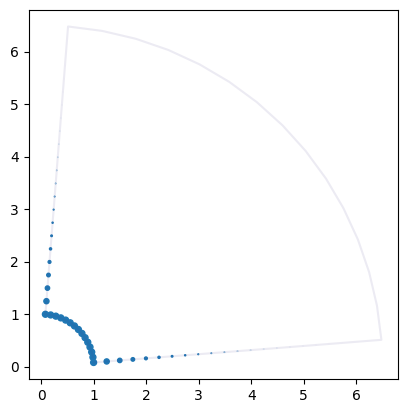

In [2]:
line_ID = 'NEG'
tracked = load_tracked(line_ID)


plt.figure()
plt.plot(tracked['coord']['x_sig'],tracked['coord']['y_sig'],alpha=0.1,color='darkslateblue')
plt.scatter(tracked['coord']['x_sig'],tracked['coord']['y_sig'],s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0))
plt.axis('square')
#plt.legend()

---
# FOOTPRINT
---

---
# SCALING WITH CURRENT
---


In [11]:
# Loading data
tracked_NEG = load_tracked_FULL('NEG')
I_oct = np.arange(-900,550+25,25)

coordinates = tracked_NEG['coord']
ctour_idx  = list(coordinates[coordinates['theta_sig'] == np.min(coordinates['theta_sig'])].index)
ctour_idx += list(coordinates[coordinates['r_sig'] == np.max(coordinates['r_sig'])].index)[1:-1]
ctour_idx += list(coordinates[coordinates['theta_sig'] == np.max(coordinates['theta_sig'])].index)[::-1]
ctour_idx += list(coordinates[coordinates['r_sig'] == np.min(coordinates['r_sig'])].index)[1:-1][::-1]


gif_current = bbplt.GIF('Octu_ramping.gif',fps=10)

for I_value in I_oct:

    fig, axs = plt.subplots(figsize=(12,9),ncols=2, nrows=2,height_ratios=[1,4])
    gs = axs[0, 0].get_gridspec()

    # remove the underlying axes
    for ax in axs[0,:]:
        ax.remove()
    axTop = fig.add_subplot(gs[0,:])


    for ax in axs[1,:]:
        ax.remove()
    axBot  = []
    axBot.append(fig.add_subplot(gs[1,0:1]))
    axBot.append(fig.add_subplot(gs[1,1:2]))
    # axBot.append(fig.add_subplot(gs[1,2:3]))

    window    = 0.03
    Qx_0,Qy_0 = 0.31, 0.32
    Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
    Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]





    #==================================
    # TOP
    plt.sca(axTop)
    plt.plot(np.arange(len(I_oct)),I_oct,'-o',color='C2',label='Octupole Current')
    vline_loc = np.argmin(np.abs(I_value-I_oct))
    plt.axvline(vline_loc,ls='-',color='k')
    plt.axhline(I_value,ls='-',color='k')
    plt.yticks(np.arange(-900,700+200,200))
    plt.xlabel('Index')
    plt.ylabel('Current (A)')
    #===================================

    #==================================
    # BOTTOM
    plt.sca(axBot[0])
    for tracked,color in zip([tracked_NEG],['k']):
        bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
        h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)
        for i in ['HO','LR']:
            #---------------
            dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
            _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
            _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

            # Scale for scale_strength factor
            dQx += _dQx*tracked['sf']
            dQy += _dQy*tracked['sf']

            #---------------
            dQx = dQx.loc[ctour_idx]
            dQy = dQy.loc[ctour_idx]
            plt.plot(dQx,dQy,'--',alpha=0.5,color=color)

            if i == 'LR':
                start,stop = len(dQx)//5,len(dQx)//5+3
                drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color='k',alpha=0.8,label = None)
            elif i =='HO':
                start,stop = len(dQx)//12,len(dQx)//12+3
                drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.5,rotate=0,color='k',alpha=0.8,label = None)



    for tracked,color,scale in zip([tracked_NEG],['C2','C1','C2'],[-550,550,-900]):
        for i in ['OCTU']:
            #---------------
            dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
            _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
            _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

            # Scale for scale_strength factor
            dQx += _dQx*tracked['sf']/scale * I_value
            dQy += _dQy*tracked['sf']/scale * I_value

            #---------------

            dQx = dQx.loc[ctour_idx]
            dQy = dQy.loc[ctour_idx]

            plt.plot(dQx,dQy,alpha=0.8,color=color)
            # plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

            start,stop = len(dQx)//5,len(dQx)//5+3
            drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=10)
            
    plt.axis('square')
    plt.xlim(np.array(Qx_lim)-Qx_0)
    plt.ylim(np.array(Qy_lim)-Qy_0)

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))


    plt.ylabel(rf'$\Delta Q_y$',fontsize=12)
    plt.xlabel(rf'$\Delta Q_x$',fontsize=12)

    plt.plot([np.nan],[np.nan],'--',alpha=0.5,color='k',label=r'HO & LR')
    plt.plot([np.nan],[np.nan],alpha=0.8,color=color,label=r'$I_{oct}$'+rf'$={I_value}$ A')
    plt.plot([np.nan],[np.nan],'P',color='C3',alpha=0.8,label= 'Working Point')
    plt.legend(fontsize=14,loc='upper right')



    window    = 0.03
    Qx_0,Qy_0 = 62.31, 60.32
    Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
    Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]

    for tracked,color,scale in zip([tracked_NEG],['C2','C1','C2'],[-550,550,-900]):
        plt.sca(axBot[1])
        for idx,toSum in enumerate([['HO','LR'],['HO','LR','OCTU']]):
            
            bbplt.workingDiagram(order=12,Qx_range=np.array(Qx_lim)-62,Qy_range = np.array(Qy_lim)-60,offset = [62,60],alpha=0.15,color='gray')
            h1, = plt.plot([Qx_0],[Qy_0],'P',color='C3',alpha=0.8)


            dQx,dQy = np.zeros(len(tracked['coord']))+Qx_0,np.zeros(len(tracked['coord']))+Qy_0
            for i in toSum:
                #---------------
                _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
                _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

                # Scale for scale_strength factor
                

                if i == 'OCTU':
                    dQx += _dQx*tracked['sf']/scale * I_value
                    dQy += _dQy*tracked['sf']/scale * I_value
                else:
                    dQx += _dQx*tracked['sf']
                    dQy += _dQy*tracked['sf']

                #---------------

            
            if idx ==0:
                dQx = dQx.loc[ctour_idx]
                dQy = dQy.loc[ctour_idx]
                plt.plot(dQx,dQy,'--',alpha=0.5,color='k')
                continue
            else:
                
                bbplt.polarmesh(dQx,dQy,alpha=0.1,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color=color)
                plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)
            
            plt.axis('square')
            plt.xlim(np.array(Qx_lim))
            plt.ylim(np.array(Qy_lim))
            plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
            plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))


            plt.ylabel(rf'$Q_y$',fontsize=12)
            plt.xlabel(rf'$Q_x$',fontsize=12)

            
            h1, = plt.plot([np.nan],[np.nan],'--',alpha=0.5,color='k',label=r'HO & LR')
            h2, = plt.plot([np.nan],[np.nan],'P',color='C3',alpha=0.8,label= 'Working Point')

            sig1, = plt.plot([np.nan],[np.nan],'o',color=color,ms=np.sqrt(30*sciStat.norm.pdf(1)/sciStat.norm.pdf(0)))
            sig2, = plt.plot([np.nan],[np.nan],'o',color=color,ms=np.sqrt(30*sciStat.norm.pdf(2)/sciStat.norm.pdf(0)))
            sig3, = plt.plot([np.nan],[np.nan],'o',color=color,ms=np.sqrt(30*sciStat.norm.pdf(3)/sciStat.norm.pdf(0)))

            
            handles = [h1,(sig1,sig2,sig3),h2]
            legLabel = ['HO & LR',r'$1 \sigma - 6.5 \sigma$','Working Point']

            #plt.legend(_handles + [tuple(handles)], _labels + [label], handler_map = {tuple : HandlerTuple(len(handles))},**kwargs)
    
            plt.legend(handles,legLabel,handler_map = {tuple : bbplt.HandlerTuple(3)},loc='upper right',fontsize=12)



    plt.tight_layout()
    gif_current.add_frame()
    plt.close()



gif_current.publish(keepframes=True)

MovieWriter ffmpeg unavailable; using Pillow instead.


---
# Summary plot
---

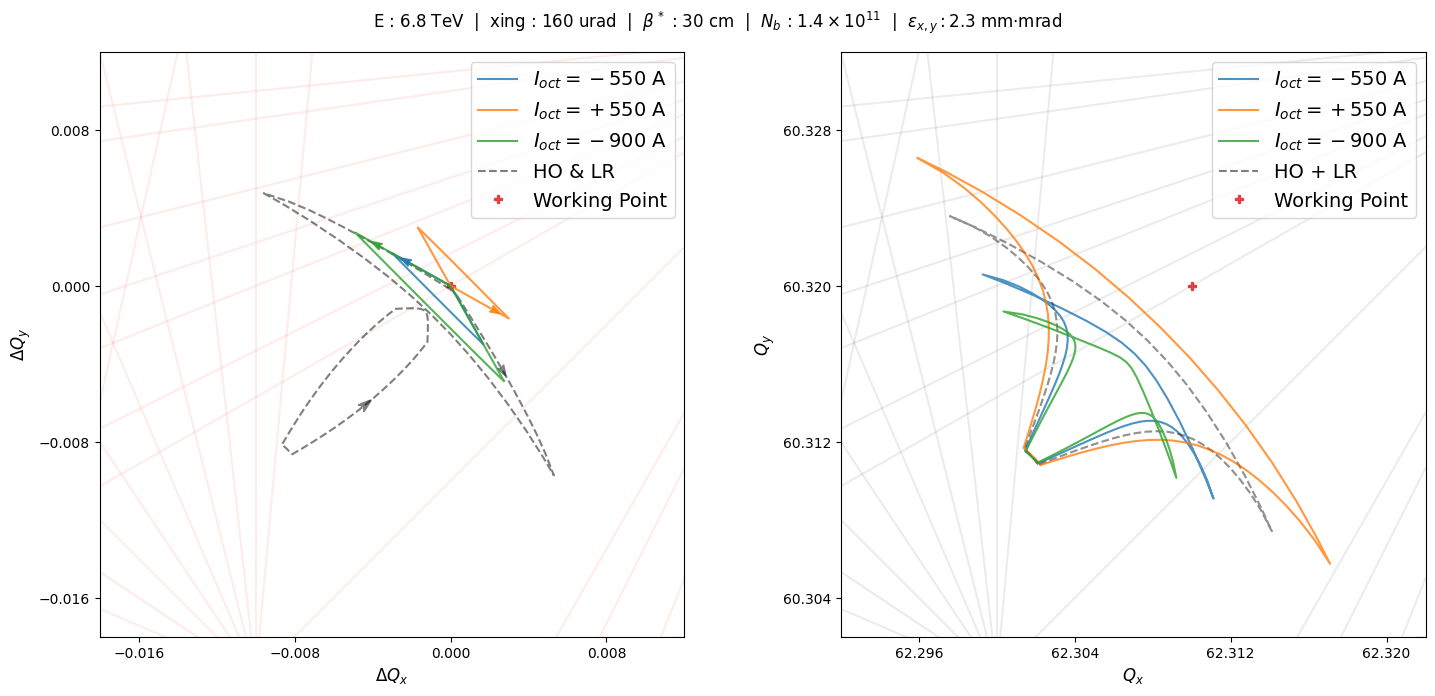

In [76]:
# Loading data
tracked_NEG = load_tracked('NEG')
tracked_POS = load_tracked('POS')
tracked_MAX = load_tracked('MAX')





fig, axs = plt.subplots(figsize=(15,7),ncols=2, nrows=1,height_ratios=[1])
axBot = axs

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]





# #==================================
# # TOP
# plt.sca(axTop)
# plt.plot(np.arange(len(I_oct)),I_oct,'-o',color='C2',label='Octupole Current')
# vline_loc = np.argmin(np.abs(I_value-I_oct))
# plt.axvline(vline_loc,ls='-',color='k')
# plt.axhline(I_value,ls='-',color='k')
# plt.yticks([-900,-550,0,550])
# #===================================

#==================================
# BOTTOM
plt.sca(axBot[0])
for tracked,color in zip([tracked_NEG],['k']):
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
    h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)
    for i in ['HO','LR']:
        #---------------
        dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
        _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
        _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

        # Scale for scale_strength factor
        dQx += _dQx*tracked['sf']
        dQy += _dQy*tracked['sf']

        #---------------
        plt.plot(dQx,dQy,'--',alpha=0.5,color=color)

        if i == 'LR':
            start,stop = len(dQx)//5,len(dQx)//5+3
            drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color='gray',alpha=1,label = None)
        elif i =='HO':
            start,stop = len(dQx)//12,len(dQx)//12+3
            drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.5,rotate=0,color='gray',alpha=1,label = None)



for tracked,color,scale in zip([tracked_NEG,tracked_POS,tracked_MAX],['C0','C1','C2'],[-550,550,-900]):
    for i in ['OCTU']:
        #---------------
        dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
        _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
        _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

        # Scale for scale_strength factor
        dQx += _dQx*tracked['sf']
        dQy += _dQy*tracked['sf']

        #---------------


        plt.plot(dQx,dQy,alpha=0.8,color=color)
        # plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

        start,stop = len(dQx)//4,len(dQx)//4+3
        drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)

plt.plot([np.nan],[np.nan],alpha=0.8,color='C0',label=r'$I_{oct} = -550$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C1',label=r'$I_{oct} = +550$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C2',label=r'$I_{oct} = -900$ A')
plt.plot([np.nan],[np.nan],'--',alpha=0.5,color='k',label=r'HO & LR')
plt.plot([np.nan],[np.nan],'P',color='C3',alpha=0.8,label= 'Working Point')
plt.legend(fontsize=14,loc='upper right')

plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))

plt.ylabel(rf'$\Delta Q_y$',fontsize=12)
plt.xlabel(rf'$\Delta Q_x$',fontsize=12)



window    = 0.03
Qx_0,Qy_0 = 62.31, 60.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]

plt.sca(axBot[1])
bbplt.workingDiagram(order=12,Qx_range=np.array(Qx_lim)-62,Qy_range = np.array(Qy_lim)-60,offset = [62,60],alpha=0.15,color='gray')
h1, = plt.plot([Qx_0],[Qy_0],'P',color='C3',alpha=0.8)
for tracked,color,scale in zip([tracked_NEG,tracked_POS,tracked_MAX],['C0','C1','C2'],[-550,550,-900]):
    
    for idx,toSum in enumerate([['HO','LR'],['HO','LR','OCTU']]):


        dQx,dQy = np.zeros(len(tracked['coord']))+Qx_0,np.zeros(len(tracked['coord']))+Qy_0
        for i in toSum:
            #---------------
            _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
            _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

            # Scale for scale_strength factor
            

    
            dQx += _dQx*tracked['sf']
            dQy += _dQy*tracked['sf']

            #---------------

        
        if idx ==0:
            plt.plot(dQx,dQy,'--',alpha=0.5/3,color='k')
        else:
            plt.plot(dQx,dQy,alpha=0.8,color=color)
        # plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)
        
        plt.axis('square')
        plt.xlim(np.array(Qx_lim))
        plt.ylim(np.array(Qy_lim))
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))


        plt.ylabel(rf'$Q_y$',fontsize=12)
        plt.xlabel(rf'$Q_x$',fontsize=12)

plt.plot([np.nan],[np.nan],alpha=0.8,color='C0',label=r'$I_{oct} = -550$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C1',label=r'$I_{oct} = +550$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C2',label=r'$I_{oct} = -900$ A')
plt.plot([np.nan],[np.nan],'--',alpha=0.5,color='k',label=r'HO + LR')
plt.plot([np.nan],[np.nan],'P',color='C3',alpha=0.8,label= 'Working Point')
plt.legend(fontsize=14,loc='upper right')

plt.suptitle(r'E : 6.8 TeV  |  xing : 160 urad  |  $\beta^*$ : 30 cm  |  $N_b$ : $1.4\times10^{11}$  |  $\varepsilon_{x,y} : 2.3$ mm$\cdot$mrad')
plt.tight_layout()

plt.savefig(f'./SummaryPlot.png',dpi=300)


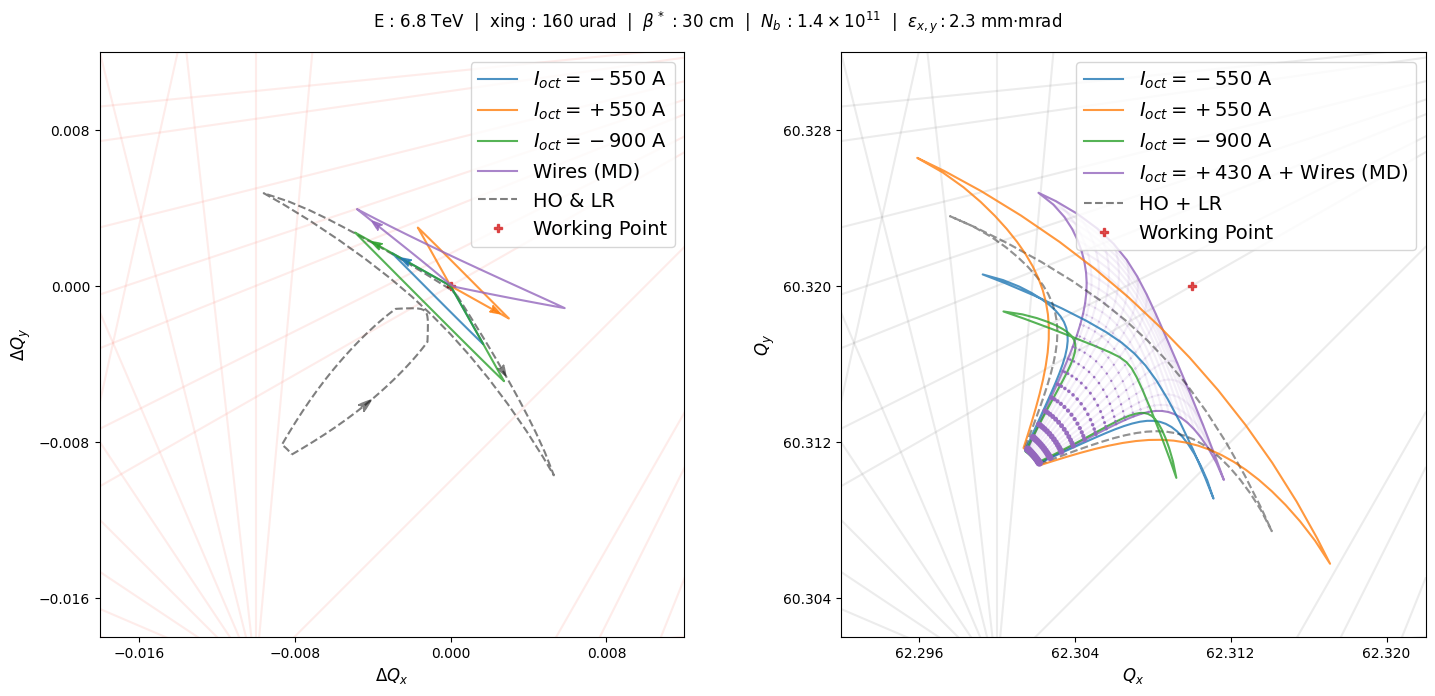

In [19]:
# Loading data
tracked_NEG = load_tracked('NEG')
tracked_POS = load_tracked('POS')
tracked_MAX = load_tracked('MAX')
tracked_FULL = load_tracked_FULL('NEG')

coordinates = tracked_FULL['coord']
ctour_idx  = list(coordinates[coordinates['theta_sig'] == np.min(coordinates['theta_sig'])].index)
ctour_idx += list(coordinates[coordinates['r_sig'] == np.max(coordinates['r_sig'])].index)[1:-1]
ctour_idx += list(coordinates[coordinates['theta_sig'] == np.max(coordinates['theta_sig'])].index)[::-1]
ctour_idx += list(coordinates[coordinates['r_sig'] == np.min(coordinates['r_sig'])].index)[1:-1][::-1]



fig, axs = plt.subplots(figsize=(15,7),ncols=2, nrows=1,height_ratios=[1])
axBot = axs

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]





# #==================================
# # TOP
# plt.sca(axTop)
# plt.plot(np.arange(len(I_oct)),I_oct,'-o',color='C2',label='Octupole Current')
# vline_loc = np.argmin(np.abs(I_value-I_oct))
# plt.axvline(vline_loc,ls='-',color='k')
# plt.axhline(I_value,ls='-',color='k')
# plt.yticks([-900,-550,0,550])
# #===================================

#==================================
# BOTTOM
plt.sca(axBot[0])
for tracked,color in zip([tracked_NEG],['k']):
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
    h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)
    for i in ['HO','LR']:
        #---------------
        dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
        _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
        _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

        # Scale for scale_strength factor
        dQx += _dQx*tracked['sf']
        dQy += _dQy*tracked['sf']

        #---------------
        plt.plot(dQx,dQy,'--',alpha=0.5,color=color)

        if i == 'LR':
            start,stop = len(dQx)//5,len(dQx)//5+3
            drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color='gray',alpha=1,label = None)
        elif i =='HO':
            start,stop = len(dQx)//12,len(dQx)//12+3
            drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.5,rotate=0,color='gray',alpha=1,label = None)



for tracked,color,scale in zip([tracked_NEG,tracked_POS,tracked_MAX],['C0','C1','C2'],[-550,550,-900]):
    for i in ['OCTU']:
        #---------------
        dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
        _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
        _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

        # Scale for scale_strength factor
        dQx += _dQx*tracked['sf']
        dQy += _dQy*tracked['sf']

        #---------------


        plt.plot(dQx,dQy,alpha=0.8,color=color)
        # plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

        start,stop = len(dQx)//4,len(dQx)//4+3
        drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)

for tracked,color,scale in zip([tracked_FULL],['C4','C1','C2'],[-550,550,-900]):
    for i in ['BBCW']:
        #---------------
        dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
        _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
        _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

        # Scale for scale_strength factor
        dQx += _dQx*tracked['sf']
        dQy += _dQy*tracked['sf']

        #---------------

        dQx,dQy = dQx.loc[ctour_idx],dQy.loc[ctour_idx]

        plt.plot(dQx,dQy,alpha=0.8,color=color)
        # plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

        start,stop = len(dQx)//4,len(dQx)//4+3
        drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None,zorder=100)


plt.plot([np.nan],[np.nan],alpha=0.8,color='C0',label=r'$I_{oct} = -550$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C1',label=r'$I_{oct} = +550$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C2',label=r'$I_{oct} = -900$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C4',label=r'Wires (MD)')
plt.plot([np.nan],[np.nan],'--',alpha=0.5,color='k',label=r'HO & LR')
plt.plot([np.nan],[np.nan],'P',color='C3',alpha=0.8,label= 'Working Point')
plt.legend(fontsize=14,loc='upper right')

plt.axis('square')
plt.xlim(np.array(Qx_lim)-Qx_0)
plt.ylim(np.array(Qy_lim)-Qy_0)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))

plt.ylabel(rf'$\Delta Q_y$',fontsize=12)
plt.xlabel(rf'$\Delta Q_x$',fontsize=12)



window    = 0.03
Qx_0,Qy_0 = 62.31, 60.32
Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]

plt.sca(axBot[1])
bbplt.workingDiagram(order=12,Qx_range=np.array(Qx_lim)-62,Qy_range = np.array(Qy_lim)-60,offset = [62,60],alpha=0.15,color='gray')
h1, = plt.plot([Qx_0],[Qy_0],'P',color='C3',alpha=0.8)


toSum = ['HO','LR','OCTU','BBCW']
tracked = tracked_FULL
dQx,dQy = np.zeros(len(tracked['coord']))+Qx_0,np.zeros(len(tracked['coord']))+Qy_0
for i in toSum:
    #---------------
    _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
    _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

    # Scale for scale_strength factor
    

    if i == 'OCTU':
        dQx += _dQx*tracked['sf']/-550*430
        dQy += _dQy*tracked['sf']/-550*430
    else:
        dQx += _dQx*tracked['sf']
        dQy += _dQy*tracked['sf']
    #---------------
color = 'C4'
bbplt.polarmesh(dQx,dQy,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot(dQx.loc[ctour_idx],dQy.loc[ctour_idx],alpha=0.8,color=color)  

for tracked,color,scale in zip([tracked_NEG,tracked_POS,tracked_MAX],['C0','C1','C2'],[-550,550,-900]):
    
    for idx,toSum in enumerate([['HO','LR'],['HO','LR','OCTU']]):


        dQx,dQy = np.zeros(len(tracked['coord']))+Qx_0,np.zeros(len(tracked['coord']))+Qy_0
        for i in toSum:
            #---------------
            _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
            _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

            # Scale for scale_strength factor
            

    
            dQx += _dQx*tracked['sf']
            dQy += _dQy*tracked['sf']

            #---------------

        
        if idx ==0:
            plt.plot(dQx,dQy,'--',alpha=0.5/3,color='k')
        else:
            plt.plot(dQx,dQy,alpha=0.8,color=color)
        # plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)
        
        plt.axis('square')
        plt.xlim(np.array(Qx_lim))
        plt.ylim(np.array(Qy_lim))
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))


        plt.ylabel(rf'$Q_y$',fontsize=12)
        plt.xlabel(rf'$Q_x$',fontsize=12)

plt.plot([np.nan],[np.nan],alpha=0.8,color='C0',label=r'$I_{oct} = -550$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C1',label=r'$I_{oct} = +550$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C2',label=r'$I_{oct} = -900$ A')
plt.plot([np.nan],[np.nan],alpha=0.8,color='C4',label=r'$I_{oct} = +430$ A + Wires (MD)')
plt.plot([np.nan],[np.nan],'--',alpha=0.5,color='k',label=r'HO + LR')
plt.plot([np.nan],[np.nan],'P',color='C3',alpha=0.8,label= 'Working Point')
plt.legend(fontsize=14,loc='upper right')

plt.suptitle(r'E : 6.8 TeV  |  xing : 160 urad  |  $\beta^*$ : 30 cm  |  $N_b$ : $1.4\times10^{11}$  |  $\varepsilon_{x,y} : 2.3$ mm$\cdot$mrad')
plt.tight_layout()

# plt.savefig(f'./SummaryPlot_WIRE.png',dpi=300)


---
# CHECKING LINEARITY
---

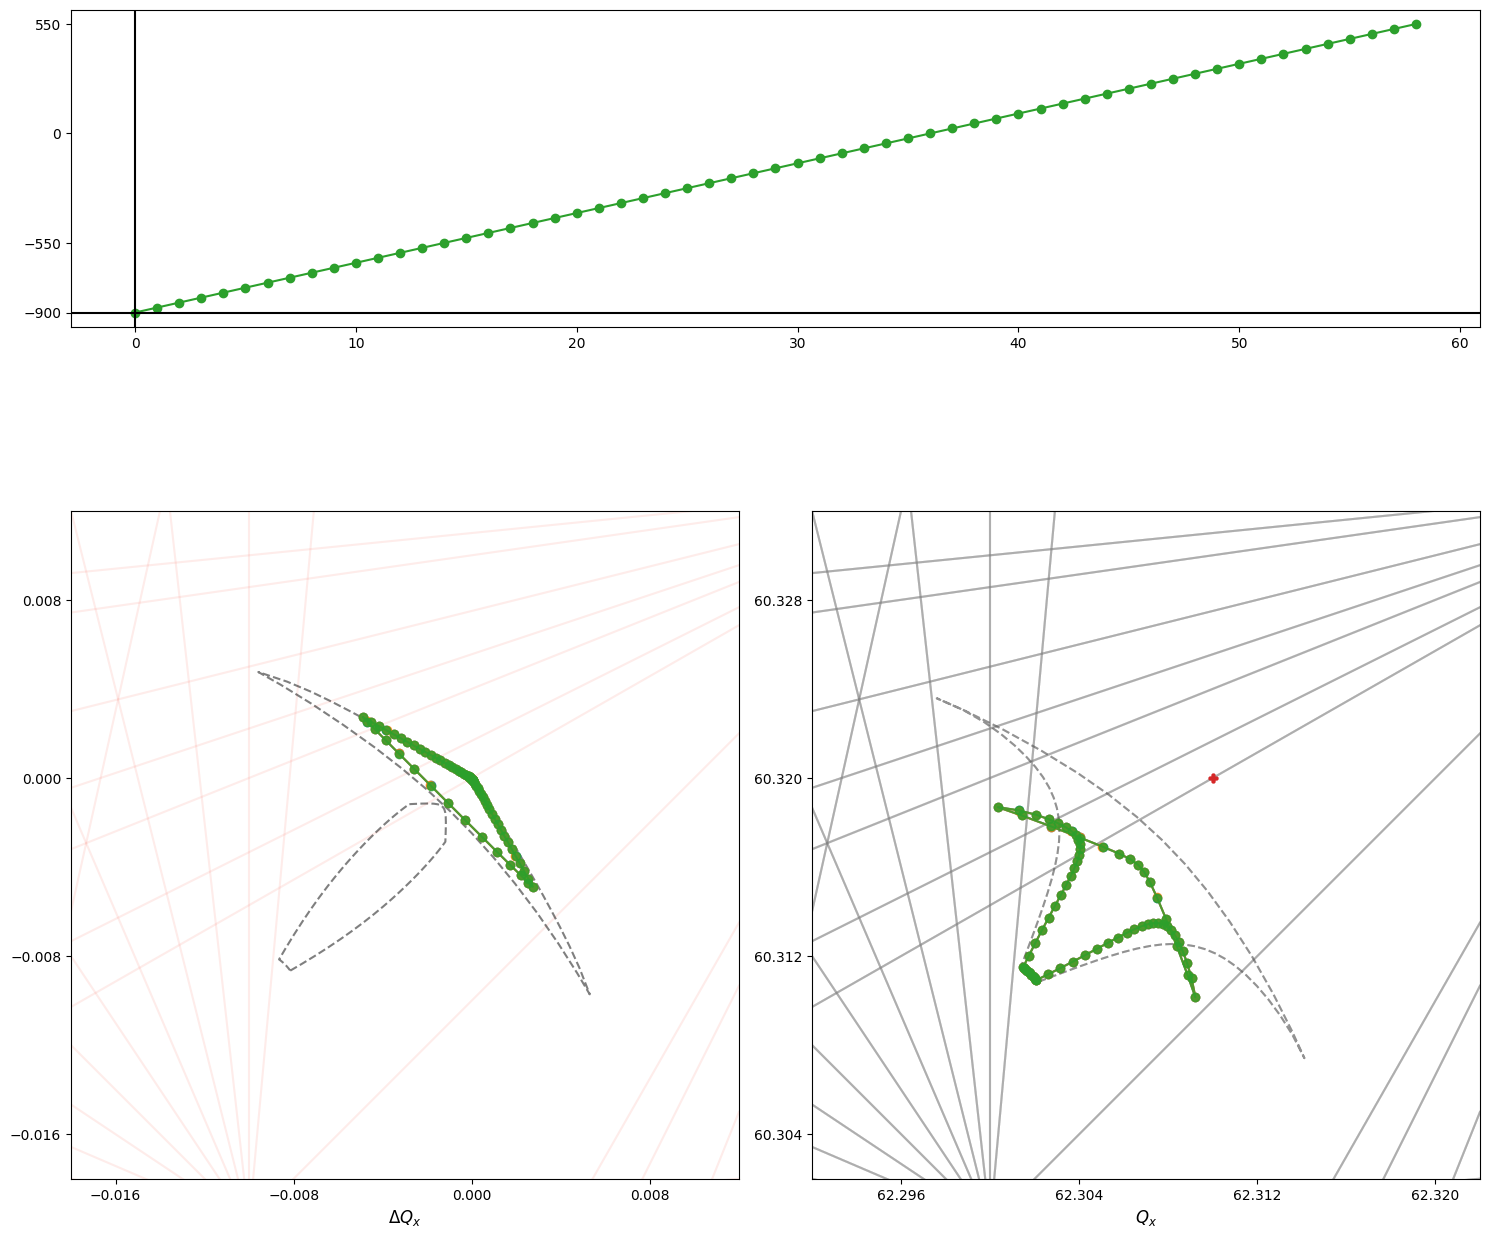

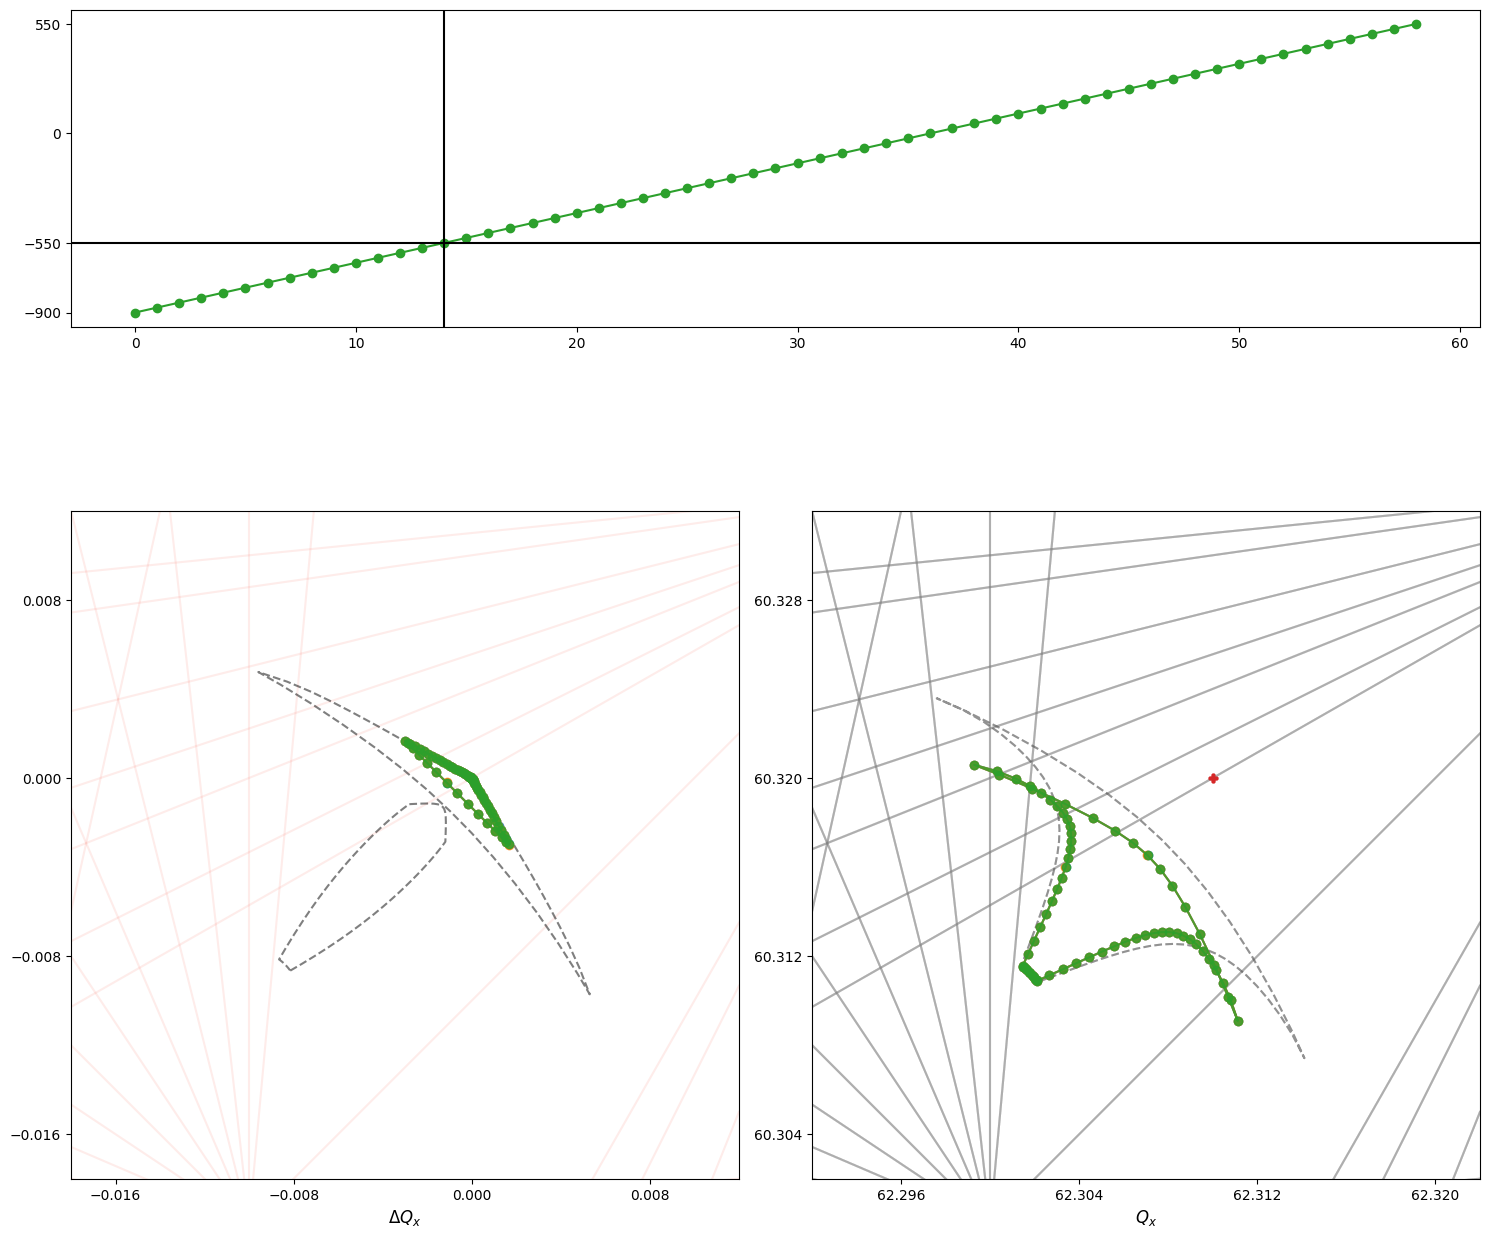

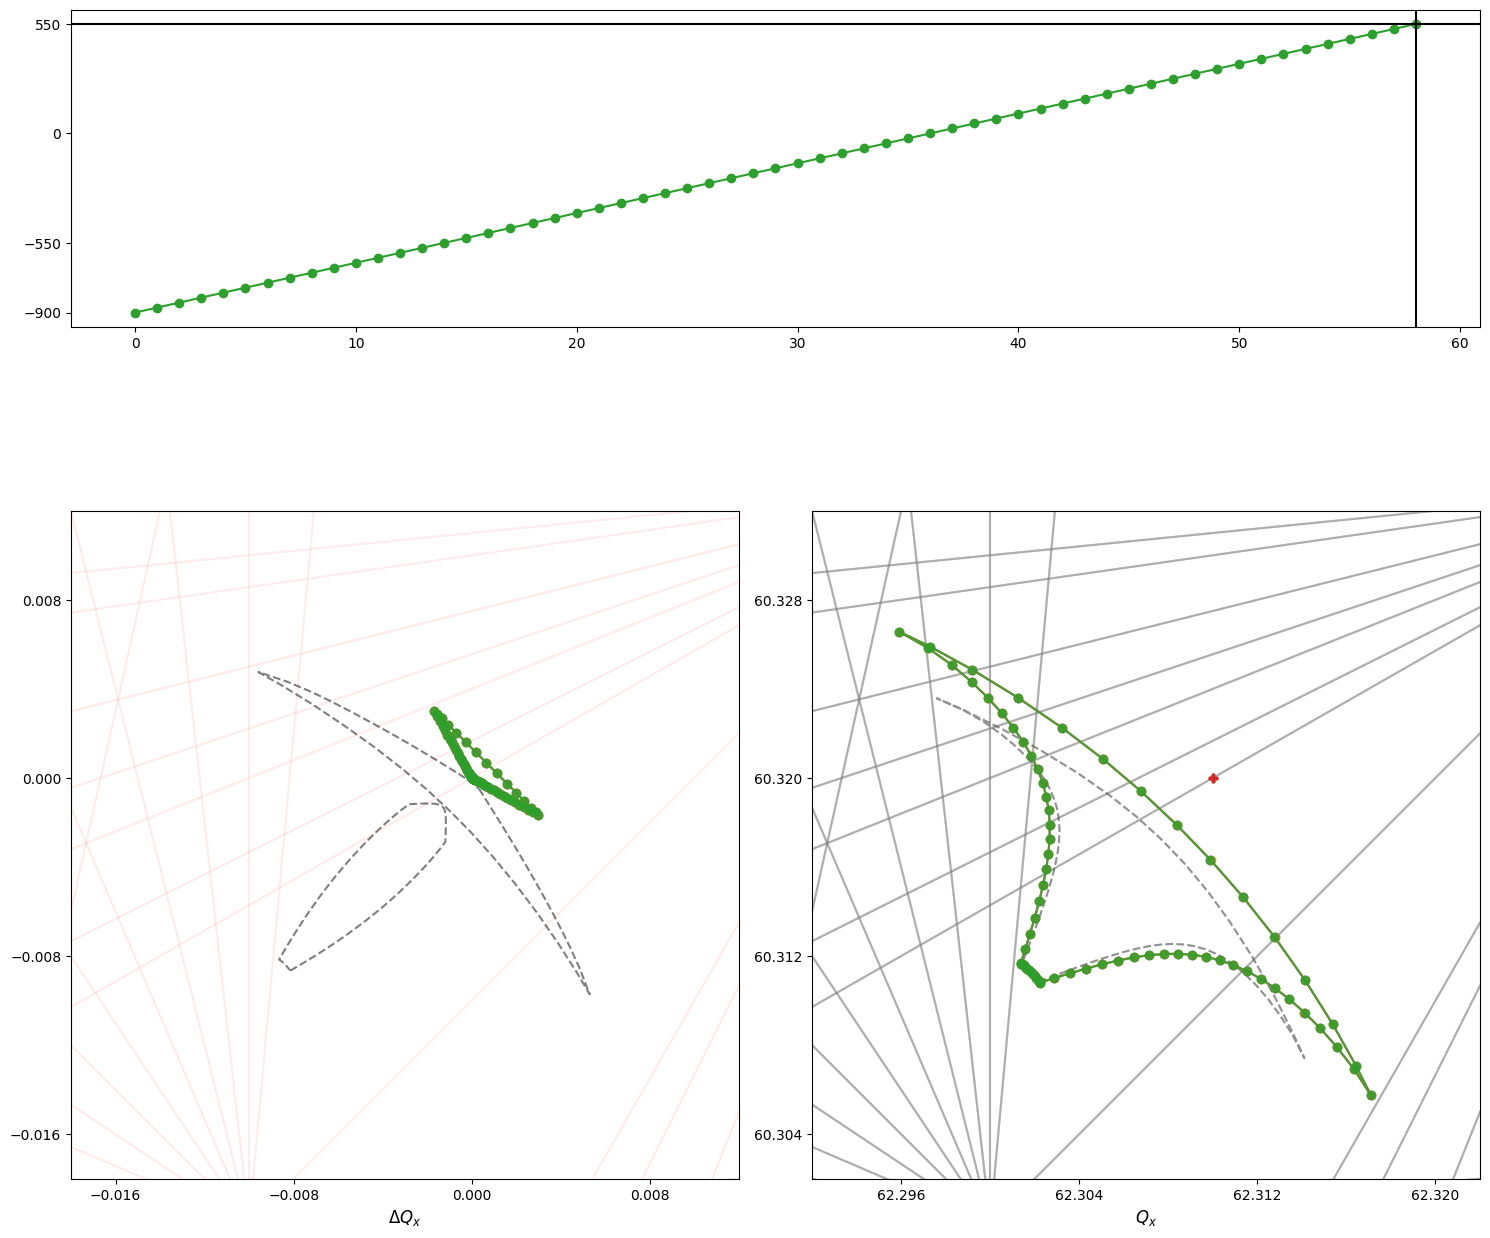

In [56]:
# Loading data
tracked_NEG = load_tracked('NEG')
tracked_POS = load_tracked('POS')
tracked_MAX = load_tracked('MAX')
I_oct = np.arange(-900,550+25,25)


for I_value in [-900,-550,550]:

    fig, axs = plt.subplots(figsize=(15,15),ncols=2, nrows=2,height_ratios=[1,4])
    gs = axs[0, 0].get_gridspec()

    # remove the underlying axes
    for ax in axs[0,:]:
        ax.remove()
    axTop = fig.add_subplot(gs[0,:])


    for ax in axs[1,:]:
        ax.remove()
    axBot  = []
    axBot.append(fig.add_subplot(gs[1,0:1]))
    axBot.append(fig.add_subplot(gs[1,1:2]))
    # axBot.append(fig.add_subplot(gs[1,2:3]))

    window    = 0.03
    Qx_0,Qy_0 = 0.31, 0.32
    Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
    Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]





    #==================================
    # TOP
    plt.sca(axTop)
    plt.plot(np.arange(len(I_oct)),I_oct,'-o',color='C2',label='Octupole Current')
    vline_loc = np.argmin(np.abs(I_value-I_oct))
    plt.axvline(vline_loc,ls='-',color='k')
    plt.axhline(I_value,ls='-',color='k')
    plt.yticks([-900,-550,0,550])
    #===================================

    #==================================
    # BOTTOM
    plt.sca(axBot[0])
    for tracked,color in zip([tracked_NEG],['k']):
        bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='salmon')
        h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)
        for i in ['HO','LR']:
            #---------------
            dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
            _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
            _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

            # Scale for scale_strength factor
            dQx += _dQx*tracked['sf']
            dQy += _dQy*tracked['sf']

            #---------------
            plt.plot(dQx,dQy,'--',alpha=0.5,color=color)

            # if i == 'LR':
            #     start,stop = len(dQx)//5,len(dQx)//5+3
            #     drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color='k',alpha=0.8,label = None)
            # elif i =='HO':
            #     start,stop = len(dQx)//12,len(dQx)//12+3
            #     drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.5,rotate=0,color='k',alpha=0.8,label = None)



    for tracked,color,scale in zip([tracked_NEG,tracked_POS,tracked_MAX],['C0','C1','C2'],[-550,550,-900]):
        for i in ['OCTU']:
            #---------------
            dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
            _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
            _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

            # Scale for scale_strength factor
            dQx += _dQx*tracked['sf']/scale * I_value
            dQy += _dQy*tracked['sf']/scale * I_value

            #---------------


            plt.plot(dQx,dQy,'-o',alpha=0.8,color=color)
            # plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)

            # start,stop = len(dQx)//5,len(dQx)//5+3
            # drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.2,rotate=0,color=color,alpha=0.8,label = None)
            
    plt.axis('square')
    plt.xlim(np.array(Qx_lim)-Qx_0)
    plt.ylim(np.array(Qy_lim)-Qy_0)

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))

    if i != 'HO':
        ax.yaxis.set_visible(False)
    else:
        plt.ylabel(rf'$\Delta Q_y$',fontsize=12)

    plt.xlabel(rf'$\Delta Q_x$',fontsize=12)



    window    = 0.03
    Qx_0,Qy_0 = 62.31, 60.32
    Qx_lim    = [Qx_0-3*window/5,Qx_0+2*window/5]
    Qy_lim    = [Qy_0-3*window/5,Qy_0+2*window/5]

    for tracked,color,scale in zip([tracked_NEG,tracked_POS,tracked_MAX],['C0','C1','C2'],[-550,550,-900]):
        plt.sca(axBot[1])
        for idx,toSum in enumerate([['HO','LR'],['HO','LR','OCTU']]):
            
            bbplt.workingDiagram(order=12,Qx_range=np.array(Qx_lim)-62,Qy_range = np.array(Qy_lim)-60,offset = [62,60],alpha=0.15,color='gray')
            h1, = plt.plot([Qx_0],[Qy_0],'P',color='C3',alpha=0.8)


            dQx,dQy = np.zeros(len(tracked['coord']))+Qx_0,np.zeros(len(tracked['coord']))+Qy_0
            for i in toSum:
                #---------------
                _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
                _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

                # Scale for scale_strength factor
                

                if i == 'OCTU':
                    dQx += _dQx*tracked['sf']/scale * I_value
                    dQy += _dQy*tracked['sf']/scale * I_value
                else:
                    dQx += _dQx*tracked['sf']
                    dQy += _dQy*tracked['sf']

                #---------------

            
            if idx ==0:
                plt.plot(dQx,dQy,'--',alpha=0.5/3,color='k')
            else:
                plt.plot(dQx,dQy,'-o',alpha=0.8,color=color)
            # plt.scatter(dQx,dQy,c=color,alpha=0.9,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0),zorder=10)
            
            plt.axis('square')
            plt.xlim(np.array(Qx_lim))
            plt.ylim(np.array(Qy_lim))
            plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
            plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))

            if ax != axBot[1]:
                ax.yaxis.set_visible(False)
            else:
                plt.ylabel(rf'$Q_y$',fontsize=12)

            plt.xlabel(rf'$Q_x$',fontsize=12)



    plt.tight_layout()
    figlabel = {-550:'NEG',550:'POS',-900:'MAX'}[I_value]
    # plt.savefig(f'./Check_Linearity/At_{figlabel}.png',dpi=300)
